In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
from glob import glob
import os
import statsmodels.api as sm
from typing import List
from sklearn.model_selection import train_test_split
import itertools
from tqdm import tqdm
from admix.data import quantile_normalize
import matplotlib.pyplot as plt
import calpgs
import subprocess
import matplotlib
import submitit

matplotlib.rcParams["font.family"] = ["Liberation Sans"]
os.environ["R_HOME"] = "/u/project/pasaniuc/kangchen/software/miniconda3/envs/r/lib/R"

In [2]:
DATA_DIR = "../compile-data/out/per-trait-info/"
DATA_URL = "../r2-diff/data-table.xlsx"

df_trait_info = pd.read_excel(DATA_URL, sheet_name=0)
trait_map = {
    row.id: row.short if row.short is not np.nan else row.description
    for _, row in df_trait_info.iterrows()
}

df_covar_info = pd.read_excel(DATA_URL, sheet_name=1)
covar_map = {row.id: row.short for _, row in df_covar_info.iterrows()}

df_display = pd.read_excel(DATA_URL, sheet_name=2)

trait_list = df_display.id.values

COVAR_COLS = [
    "AGE",
    "SEX",
    "DEPRIVATION_INDEX",
    "log_BMI",
    "income",
    "ever_smoked",
    "drink_alcohol",
    "glasses",
    "years_of_edu",
] + [f"PC{i}" for i in range(1, 5)]
FIT_COLS = ["PGS"] + COVAR_COLS

In [3]:
def estimate(df, mean_cols, var_cols, slope_cols=None):
    df = df.copy()
    # format data set
    mean_covar = sm.add_constant(df[mean_cols])
    var_covar = sm.add_constant(df[var_cols])
    y = df["pheno"].values

    if slope_cols is None:
        slope_covar = None
    else:
        slope_covar = df[slope_cols]
    if slope_cols is not None:
        print("Slope columns: " + " ".join(slope_cols))
    fit = calpgs.fit_het_linear(
        y=y,
        mean_covar=mean_covar,
        var_covar=var_covar,
        slope_covar=slope_covar,
        return_est_covar=True,
        trace=True,
    )

    if slope_cols is None:
        beta, gamma, beta_cov, gamma_cov = fit
    else:
        beta, gamma, slope_coef, beta_cov, gamma_cov, slope_vcov = fit
    beta_se = np.sqrt(np.diag(beta_cov))
    gamma_se = np.sqrt(np.diag(gamma_cov))

    df_beta_params = pd.DataFrame(
        {"beta": beta, "beta_se": beta_se, "beta_z": beta / beta_se},
        index=mean_covar.columns,
    )
    df_gamma_params = pd.DataFrame(
        {
            "gamma": gamma,
            "gamma_se": gamma_se,
            "gamma_z": gamma / gamma_se,
        },
        index=var_covar.columns,
    )

    df_params = pd.merge(
        df_beta_params, df_gamma_params, left_index=True, right_index=True, how="outer"
    )

    if slope_cols is None:
        pred_mean = mean_covar.dot(beta)
        pred_std = np.sqrt(np.exp(var_covar.dot(gamma)))
    else:
        pred_slope = 1 + slope_covar.dot(slope_coef)
        pred_mean = mean_covar.dot(beta) * pred_slope
        pred_std = np.sqrt(np.exp(var_covar.dot(gamma)))
        slope_coef_se = np.sqrt(np.diag(slope_vcov))
        df_slope_params = pd.DataFrame(
            {
                "slope": slope_coef,
                "slope_se": slope_coef_se,
                "slope_z": slope_coef / slope_coef_se,
            },
            index=slope_covar.columns,
        )
        df_params = pd.merge(
            df_params, df_slope_params, left_index=True, right_index=True, how="outer"
        )
        df["cal_slope"] = pred_slope

    df["cal_pred"], df["cal_predstd"] = pred_mean, pred_std
    return df_params, df

In [4]:
def fit_params(trait, indiv_group, method, out_prefix, center_pheno=False):
    """Fit parameters

    Parameters
    ----------
    trait: str
        trait
    indiv_group: str
        individual group
    method: str
        marginal, joint, marginal+interact, joint+interact
    out_prefix: str
        output prefix
    """
    df_trait = pd.read_csv(
        os.path.join(DATA_DIR, f"{trait}.tsv.gz"), index_col=0, sep="\t"
    )

    if indiv_group == "white":
        df_trait = df_trait[df_trait.group == "United Kingdom"]
    elif indiv_group == "other":
        df_trait = df_trait[~(df_trait.group == "United Kingdom")]
    else:
        raise NotImplementedError

    df_trait = df_trait.rename(columns={"MEAN": "PGS", "PHENO": "pheno"}).dropna(
        subset=["pheno", "PGS"]
    )

    # impute with column average and standardize covariates
    for col in ["PGS"] + COVAR_COLS:
        df_trait[col] = df_trait[col].fillna(df_trait[col].mean())
        df_trait[col] = (df_trait[col] - df_trait[col].mean()) / df_trait[col].std()

    df_trait = df_trait[["pheno", "PGS"] + COVAR_COLS]

    ## centering phenotype
    if center_pheno:
        df_trait["pheno"] -= df_trait["pheno"].mean()

    fit_cols = [col for col in FIT_COLS if col != trait]

    if method == "joint":
        df_params, df_cal = estimate(df_trait, mean_cols=fit_cols, var_cols=fit_cols)
        df_cal.to_csv(out_prefix + ".predint.tsv", sep="\t", float_format="%.6g")
    elif method == "joint+slope":
        df_params, df_cal = estimate(
            df_trait, mean_cols=fit_cols, var_cols=fit_cols, slope_cols=fit_cols
        )
        df_cal.to_csv(out_prefix + ".predint.tsv", sep="\t", float_format="%.6g")
    elif method == "marginal":
        ### fit a marginal parameter for each covariate
        df_params = []
        for col in fit_cols:
            df_tmp_params = estimate(df_trait, mean_cols=fit_cols, var_cols=[col])[0]
            df_params.append(df_tmp_params.loc[col].iloc[3:])
        df_params = pd.DataFrame(df_params)
    else:
        raise NotImplementedError
    df_params.to_csv(
        out_prefix + ".params.tsv", sep="\t", float_format="%.6g", na_rep="NA"
    )

In [5]:
df_params = pd.DataFrame(
    [params for params in itertools.product(trait_list, ["white", "other"])],
    columns=["trait", "group"],
)

In [11]:
def submit(trait, group):
    for method in ["marginal", "joint", "joint+slope"]:
        os.makedirs(f"out/model-fit/{method}", exist_ok=True)
        fit_params(trait, group, method, f"out/model-fit/{method}/{trait}-{group}")

In [12]:
executor = submitit.SgeExecutor(folder="./submitit-logs")

executor.update_parameters(
    time_min=60,
    memory_g=16,
    setup=[
        "export PATH=~/project-pasaniuc/software/miniconda3/bin:$PATH",
        "export PYTHONNOUSERSITE=True",
        "export R_HOME=/u/project/pasaniuc/kangchen/software/miniconda3/envs/r/lib/R",
    ],
)

jobs = executor.map_array(
    submit,
    df_params.trait,
    df_params.group,
)

# Summarize results

In [7]:
os.makedirs("out/fit-summary", exist_ok=True)
dict_df_gamma = dict()

for method in ["marginal", "joint", "joint+slope"]:
    save_slope = method == "joint+slope"
    for group in ["white", "other"]:
        df_gamma = pd.DataFrame(index=FIT_COLS, columns=trait_list)
        if save_slope:
            df_slope = pd.DataFrame(index=FIT_COLS, columns=trait_list)
        for trait in trait_list:
            df = pd.read_csv(
                f"out/model-fit/{method}/{trait}-{group}.params.tsv",
                sep="\t",
                index_col=0,
            )
            # store gamma
            df_gamma[trait] = df["gamma_z"]

            if save_slope:
                # store interaction beta
                df_slope[trait] = df["slope_z"]

            df_gamma.to_csv(
                f"out/fit-summary/{method}-{group}.gamma.tsv",
                float_format="%.6g",
                sep="\t",
                na_rep="NA",
            )
        dict_df_gamma[method, group] = df_gamma
        if save_slope:
            df_slope.to_csv(
                f"out/fit-summary/{method}-{group}.slope.tsv",
                float_format="%.6g",
                sep="\t",
                na_rep="NA",
            )

# preview results

In [8]:
def compare_zscore(xkey, ykey, xlabel=None, ylabel=None):
    fig, axes = plt.subplots(
        figsize=(6, 3),
        dpi=150,
        ncols=2,
    )

    lim = 0
    for i, group in enumerate(["white", "other"]):
        ax = axes[i]
        x = dict_df_gamma[xkey, group].values.flatten()
        y = dict_df_gamma[ykey, group].values.flatten()
        lim = max(np.nanmax(np.abs(x)), np.nanmax(np.abs(y)))
        ax.scatter(
            x,
            y,
            s=5,
            color="blue",
        )
        ax.axline((0, 0), slope=1, ls="--", color="black", alpha=0.5, lw=0.8)
        ax.set_xlabel(xlabel + r" $\widehat{\beta_\sigma}$ z-score")
        ax.set_ylabel(ylabel + r" $\widehat{\beta_\sigma}$ z-score")
        name = {"white": "WB", "other": "Diverse"}[group]
        ax.set_title(name)
    lim *= 1.2
    for i in range(2):
        axes[i].set_xlim(-lim, lim)
        axes[i].set_ylim(-lim, lim)

    fig.tight_layout()
    fig.show()

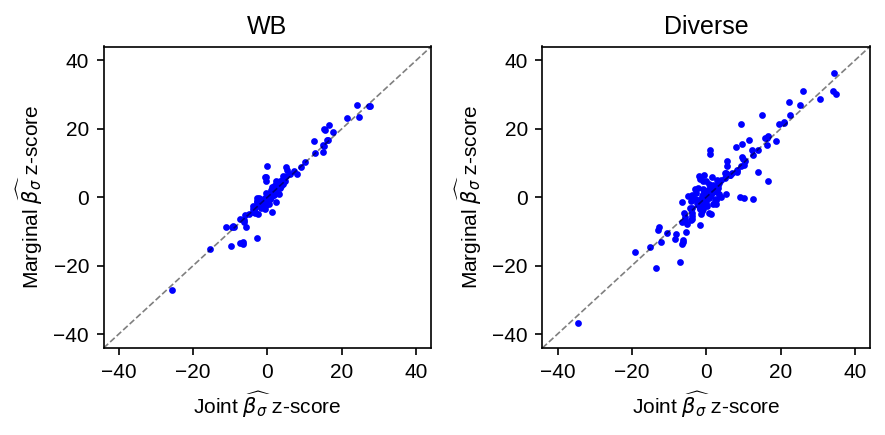

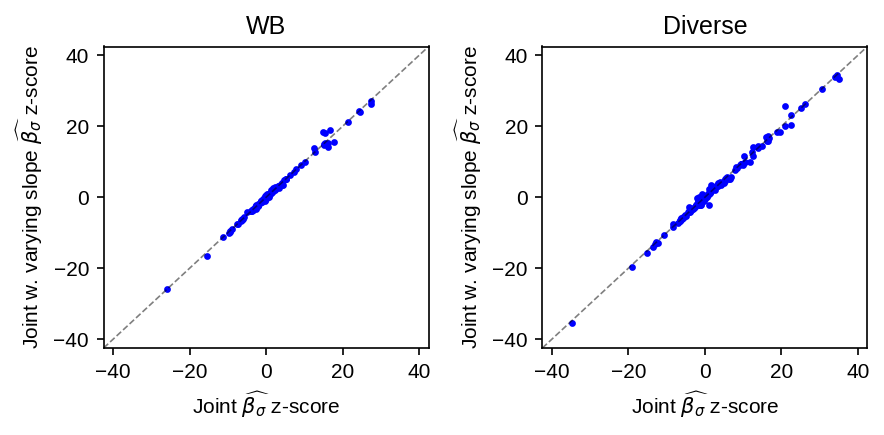

In [9]:
compare_zscore(xkey="joint", ykey="marginal", xlabel="Joint", ylabel="Marginal")
compare_zscore(
    xkey="joint", ykey="joint+slope", xlabel="Joint", ylabel="Joint w. varying slope"
)